![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# RAG - Retrieval Augmented Generation

## Objetivos de aprendizaje

Al finalizar esta notebook seras capaz de:

1. Entender que es RAG y por que es necesario
2. Implementar un pipeline RAG completo paso a paso
3. Crear embeddings y almacenarlos en una base de datos vectorial
4. Construir chains con LCEL (LangChain Expression Language)
5. Comparar respuestas sin RAG vs con RAG de forma sistematica
6. Visualizar el proceso de retrieval con t-SNE
7. Experimentar con el parametro k y entender su impacto

---
## Que es RAG?

**RAG (Retrieval Augmented Generation)** es un patron que combina busqueda de informacion con generacion de texto.

```
                    +------------------+
                    |    Pregunta      |
                    |    del usuario   |
                    +--------+---------+
                             |
                             v
                    +------------------+
                    |   RETRIEVER      |     Busca documentos
                    |   (Base          |     relevantes en la
                    |   Vectorial)     |     base de conocimiento
                    +--------+---------+
                             |
                             v
              +-----------------------------+
              |  Contexto recuperado         |
              |  (documentos relevantes)     |
              +-------------+---------------+
                             |
                             v
                    +------------------+
                    |   GENERATOR      |     El LLM genera una
                    |   (LLM)          |     respuesta basada en
                    |                  |     el contexto + pregunta
                    +--------+---------+
                             |
                             v
                    +------------------+
                    |   Respuesta      |
                    |   fundamentada   |
                    +------------------+
```

### Por que necesitamos RAG?

Los LLMs tienen dos problemas fundamentales:

1. **Alucinaciones**: inventan informacion cuando no saben la respuesta
2. **Datos privados**: no tienen acceso a informacion interna de tu empresa

RAG resuelve ambos: le da al modelo informacion real y especifica antes de generar la respuesta.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from dotenv import find_dotenv, load_dotenv
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
import warnings
warnings.filterwarnings('ignore')

load_dotenv(find_dotenv())

print("Todas las dependencias cargadas correctamente.")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias cargadas correctamente.


---
## Seccion 1: El Problema

Vamos a demostrar por que necesitamos RAG con un ejemplo concreto. Le haremos preguntas a un LLM sobre una empresa ficticia llamada **NovaTech Solutions**. Como la empresa no existe, el modelo no puede saber las respuestas.

In [2]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Pregunta directa (sin RAG)
respuesta_sin_rag = llm.invoke(
    "Cuantos dias de vacaciones tienen los empleados de NovaTech Solutions?"
)

print("Pregunta: Cuantos dias de vacaciones tienen los empleados de NovaTech Solutions?")
print("\nRespuesta del LLM (sin RAG):")
print(respuesta_sin_rag.content)
print("\n" + "=" * 60)
print("Respuesta correcta: 22 dias habiles al anio.")
print("El modelo no puede saberlo porque NovaTech es ficticia.")

Pregunta: Cuantos dias de vacaciones tienen los empleados de NovaTech Solutions?

Respuesta del LLM (sin RAG):
Lo siento, pero no tengo acceso a información específica sobre las políticas de vacaciones de NovaTech Solutions, ya que estas pueden variar según la empresa, la ubicación y el tipo de contrato de los empleados. Te recomendaría consultar el manual del empleado de la empresa o contactar al departamento de recursos humanos de NovaTech Solutions para obtener información precisa y actualizada sobre sus políticas de vacaciones.

Respuesta correcta: 22 dias habiles al anio.
El modelo no puede saberlo porque NovaTech es ficticia.


---
## Seccion 2: Preparar los Documentos

Nuestra base de conocimiento son 8 documentos internos de NovaTech Solutions. Contienen datos muy especificos que el LLM no puede adivinar.

In [3]:
novatech_docs = [
    # Politica de vacaciones
    """Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 
    44 dias. Los primeros 6 meses son periodo de prueba y solo se acumulan 1.5 dias por mes. 
    Las vacaciones deben solicitarse con al menos 15 dias de anticipacion a traves del sistema 
    interno VacaTrack v3.2. El periodo de vacaciones colectivas es del 23 de diciembre al 2 de 
    enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del salario base.""",

    # Plan de salud
    """Plan de Salud Corporativo NovaTech. La empresa ofrece cobertura medica a traves de 
    MediPlus Premium para todos los empleados y sus dependientes directos. La cobertura 
    incluye: consultas generales y especialistas con copago de $150 MXN, hospitalizacion 
    con cobertura al 90%, medicamentos con descuento del 40% en FarmaRed, dental basico 
    incluido. El tope anual de cobertura es de $2,000,000 MXN por beneficiario. La empresa 
    absorbe el 80% de la prima mensual y el empleado el 20% restante.""",

    # Proceso de onboarding
    """Proceso de Onboarding en NovaTech Solutions. El programa de integracion dura 4 semanas 
    y sigue la metodologia NOVA-Start. Semana 1: Setup tecnico (laptop, cuentas, VPN). 
    Semana 2: Sesiones con cada area del producto e introduccion a la arquitectura. Semana 3: 
    Asignacion de buddy (mentor) y primer ticket de practica en el sprint actual. Semana 4: 
    Evaluacion de onboarding con el tech lead y definicion de OKRs del primer trimestre. Cada 
    nuevo empleado recibe un kit de bienvenida con laptop Dell XPS 15 y $5,000 MXN para 
    setup de home office.""",

    # Stack tecnologico
    """Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.12, con 
    PostgreSQL 16 como base de datos principal y Redis 7.2 para cache y colas. Frontend: 
    React 18 con TypeScript 5.3, Next.js 14 para SSR, y TailwindCSS 3.4. Infraestructura: 
    AWS con EKS (Kubernetes 1.28), Terraform para IaC y ArgoCD para GitOps. CI/CD: GitLab CI 
    con pipelines de ~8 minutos promedio. El monorepo tiene 340,000 lineas de codigo y 94% 
    de cobertura de tests.""",

    # Evaluaciones de desempeno
    """Sistema de Evaluaciones de NovaTech. Las evaluaciones se realizan cada 6 meses usando 
    la plataforma NovaPerf v2.1. El proceso incluye: autoevaluacion (20%), evaluacion del 
    manager (40%), evaluacion de peers (30%) y evaluacion de reportes (10%). La escala es 
    de 1 a 5. Los empleados con calificacion 4+ son elegibles para el programa Fast Track 
    con aumento salarial del 15-20% y acceso a proyectos estrategicos.""",

    # Politica de trabajo remoto
    """Politica de Trabajo Remoto NovaTech. Modelo hibrido 3-2: 3 dias en oficina (martes, 
    miercoles, jueves) y 2 dias remotos (lunes, viernes). Oficinas en CDMX (Torre NOVA, 
    Santa Fe) y Guadalajara (WeWork Midtown). Trabajo 100% remoto temporal hasta 4 semanas 
    al anio con aprobacion del VP. Subsidio mensual de internet: $800 MXN. Se proporciona 
    silla ergonomica Herman Miller Aeron en comodato.""",

    # Programa de capacitacion
    """Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un presupuesto 
    anual de $25,000 MXN para capacitacion profesional. Cubre: cursos online (Udemy, Coursera, 
    Platzi), conferencias (hasta 2 al anio con viaticos), certificaciones tecnicas (AWS, GCP, 
    Kubernetes). La plataforma interna LearnHub tiene 150+ cursos. Los viernes de 2-4 PM son 
    'Learning Hours' protegidas. El programa de mentoria NOVA-Grow conecta juniors con seniors 
    por 6 meses.""",

    # Producto DataPulse
    """DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataforma de 
    analytics en tiempo real para e-commerce y fintech. Procesa 2.3 millones de eventos por 
    minuto con latencia p99 de 45ms. SLA garantizado: 99.95% de disponibilidad mensual, con 
    creditos del 10% por cada 0.01% debajo del SLA. Tiene 3 tiers: Starter ($2,500 USD/mes), 
    Business ($8,000 USD/mes) y Enterprise (custom). Actualmente 847 clientes en 12 paises.""",
]

print(f"Documentos cargados: {len(novatech_docs)}")
for i, doc in enumerate(novatech_docs):
    titulo = doc.strip().split('.')[0]
    print(f"  {i+1}. {titulo} ({len(doc)} chars)")

Documentos cargados: 8
  1. Politica de Vacaciones de NovaTech Solutions (579 chars)
  2. Plan de Salud Corporativo NovaTech (513 chars)
  3. Proceso de Onboarding en NovaTech Solutions (573 chars)
  4. Stack Tecnologico de NovaTech Solutions (481 chars)
  5. Sistema de Evaluaciones de NovaTech (430 chars)
  6. Politica de Trabajo Remoto NovaTech (410 chars)
  7. Programa de Capacitacion y Desarrollo NovaTech (486 chars)
  8. DataPulse - Producto Principal de NovaTech Solutions (457 chars)


In [4]:
# Chunking con RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
)

# Crear documentos LangChain
documents = []
for i, doc_text in enumerate(novatech_docs):
    titulo = doc_text.strip().split('.')[0]
    chunks = text_splitter.split_text(doc_text)
    for chunk in chunks:
        documents.append(Document(
            page_content=chunk,
            metadata={"source": titulo, "doc_id": i}
        ))

print(f"Documentos originales: {len(novatech_docs)}")
print(f"Chunks generados: {len(documents)}")
print(f"Largo promedio por chunk: {np.mean([len(d.page_content) for d in documents]):.0f} chars")

Documentos originales: 8
Chunks generados: 11
Largo promedio por chunk: 356 chars


---
## Seccion 3: Crear Embeddings

Un **embedding** es un vector numerico que captura el significado semantico del texto. Textos con significados similares tendran vectores cercanos en el espacio.

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Demostrar como funciona un embedding
ejemplo = embeddings.embed_query("vacaciones de los empleados")

print(f"Texto: 'vacaciones de los empleados'")
print(f"Dimensiones del vector: {len(ejemplo)}")
print(f"Primeros 10 valores: {ejemplo[:10]}")

Texto: 'vacaciones de los empleados'
Dimensiones del vector: 1536
Primeros 10 valores: [0.009613280184566975, 0.04032536968588829, 0.043349772691726685, 0.00849113054573536, -0.017150284722447395, 0.0066368840634822845, -0.0122776348143816, 0.0491105392575264, 0.030027998611330986, -0.049206554889678955]


In [6]:
# Demostrar similitud entre frases
client = OpenAI()
frases_demo = [
    "dias de vacaciones del empleado",
    "descanso laboral del trabajador",
    "stack tecnologico del backend",
]

resp = client.embeddings.create(input=frases_demo, model="text-embedding-3-small")
embs = np.array([e.embedding for e in resp.data])

sims = cosine_similarity(embs)
print("Similitud coseno entre frases:")
print("=" * 60)
for i in range(len(frases_demo)):
    for j in range(i + 1, len(frases_demo)):
        print(f"  '{frases_demo[i]}'")
        print(f"  '{frases_demo[j]}'")
        print(f"  -> {sims[i][j]:.4f}")
        print("-" * 50)

print("\nLas frases semanticamente similares tienen mayor similitud,")
print("sin importar que usen palabras diferentes.")

Similitud coseno entre frases:
  'dias de vacaciones del empleado'
  'descanso laboral del trabajador'
  -> 0.7018
--------------------------------------------------
  'dias de vacaciones del empleado'
  'stack tecnologico del backend'
  -> 0.1789
--------------------------------------------------
  'descanso laboral del trabajador'
  'stack tecnologico del backend'
  -> 0.1833
--------------------------------------------------

Las frases semanticamente similares tienen mayor similitud,
sin importar que usen palabras diferentes.


---
## Seccion 4: Base de Datos Vectorial

Almacenamos los embeddings en **ChromaDB** para poder buscar documentos por similitud semantica.

In [7]:
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
)

print(f"Base vectorial creada con {vectorstore._collection.count()} chunks")

Base vectorial creada con 11 chunks


---
## Seccion 5: Retrieval

El **retriever** busca los documentos mas relevantes para una pregunta dada.

In [8]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Probar el retriever
query = "cuantos dias de vacaciones tienen los empleados"
docs_recuperados = retriever.invoke(query)

print(f"Query: '{query}'")
print(f"Documentos recuperados: {len(docs_recuperados)}")
print("=" * 60)
for i, doc in enumerate(docs_recuperados, 1):
    print(f"\n--- Documento {i} (fuente: {doc.metadata.get('source', 'N/A')}) ---")
    print(doc.page_content[:200] + "...")

Query: 'cuantos dias de vacaciones tienen los empleados'
Documentos recuperados: 3

--- Documento 1 (fuente: Politica de Vacaciones de NovaTech Solutions) ---
Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 
    44 dias. Los prime...

--- Documento 2 (fuente: Politica de Vacaciones de NovaTech Solutions) ---
enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del salario base....

--- Documento 3 (fuente: Plan de Salud Corporativo NovaTech) ---
absorbe el 80% de la prima mensual y el empleado el 20% restante....


---
## Seccion 6: Generacion con LCEL

Ahora conectamos todo: retriever + prompt + LLM usando **LCEL (LangChain Expression Language)** con el operador pipe (`|`).

In [9]:
# Prompt template
template = """Eres un asistente de NovaTech Solutions. Responde la pregunta basandote 
UNICAMENTE en el contexto proporcionado. Si la informacion no esta en el contexto, 
di "No tengo informacion sobre eso en mi base de conocimiento".

Contexto:
{context}

Pregunta: {question}

Respuesta:"""

prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# LCEL chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Probar
respuesta = rag_chain.invoke("cuantos dias de vacaciones tienen los empleados?")
print("Pregunta: cuantos dias de vacaciones tienen los empleados?")
print("\nRespuesta (con RAG):")
print(respuesta)

Pregunta: cuantos dias de vacaciones tienen los empleados?

Respuesta (con RAG):
Los empleados de tiempo completo tienen derecho a 22 días hábiles de vacaciones al año.


---
## Seccion 7: COMPARACION SIN RAG vs CON RAG

Esta es la seccion mas importante. Vamos a comparar sistematicamente las respuestas del LLM con y sin RAG usando 5 preguntas sobre datos que el modelo no puede adivinar.

In [10]:
def comparar_sin_con_rag(pregunta, rag_chain, llm, respuesta_esperada):
    """Compara respuesta sin RAG vs con RAG para una pregunta."""
    # Sin RAG
    sin_rag = llm.invoke(pregunta).content

    # Con RAG
    con_rag = rag_chain.invoke(pregunta)

    return {
        'pregunta': pregunta,
        'sin_rag': sin_rag,
        'con_rag': con_rag,
        'esperada': respuesta_esperada,
    }

In [11]:
preguntas = [
    {
        'pregunta': 'Cuantos dias de vacaciones tienen los empleados de NovaTech Solutions?',
        'esperada': '22 dias habiles al anio, acumulables hasta 44 dias',
        'keyword': '22',
    },
    {
        'pregunta': 'Cual es el stack tecnologico del backend de NovaTech?',
        'esperada': 'FastAPI sobre Python 3.12, PostgreSQL 16, Redis 7.2',
        'keyword': 'FastAPI',
    },
    {
        'pregunta': 'Que es DataPulse y cual es su SLA?',
        'esperada': 'Plataforma de analytics en tiempo real. SLA: 99.95%',
        'keyword': '99.95',
    },
    {
        'pregunta': 'Como funciona el proceso de onboarding en NovaTech?',
        'esperada': '4 semanas con metodologia NOVA-Start, buddy system en semana 3',
        'keyword': '4 semanas',
    },
    {
        'pregunta': 'Cual es el presupuesto de capacitacion por empleado en NovaTech?',
        'esperada': '$25,000 MXN anuales, plataforma interna LearnHub',
        'keyword': '25,000',
    },
]

resultados = []
for p in preguntas:
    resultado = comparar_sin_con_rag(p['pregunta'], rag_chain, llm, p['esperada'])
    resultado['keyword'] = p['keyword']
    resultados.append(resultado)
    print(f"Procesada: {p['pregunta'][:50]}...")

print(f"\n{len(resultados)} comparaciones completadas.")

Procesada: Cuantos dias de vacaciones tienen los empleados de...


Procesada: Cual es el stack tecnologico del backend de NovaTe...


Procesada: Que es DataPulse y cual es su SLA?...


Procesada: Como funciona el proceso de onboarding en NovaTech...


Procesada: Cual es el presupuesto de capacitacion por emplead...

5 comparaciones completadas.


In [12]:
# Mostrar resultados detallados
for i, r in enumerate(resultados, 1):
    print(f"\n{'=' * 60}")
    print(f"PREGUNTA {i}: {r['pregunta']}")
    print(f"{'=' * 60}")
    print(f"\nRespuesta esperada: {r['esperada']}")
    print(f"\n--- SIN RAG ---")
    print(r['sin_rag'][:300])
    print(f"\n--- CON RAG ---")
    print(r['con_rag'][:300])


PREGUNTA 1: Cuantos dias de vacaciones tienen los empleados de NovaTech Solutions?

Respuesta esperada: 22 dias habiles al anio, acumulables hasta 44 dias

--- SIN RAG ---
Lo siento, pero no tengo acceso a información específica sobre las políticas de vacaciones de NovaTech Solutions. Te recomendaría consultar el manual del empleado de la empresa o contactar al departamento de recursos humanos para obtener detalles precisos sobre sus políticas de vacaciones.

--- CON RAG ---
Los empleados de tiempo completo de NovaTech Solutions tienen derecho a 22 días hábiles de vacaciones al año.

PREGUNTA 2: Cual es el stack tecnologico del backend de NovaTech?

Respuesta esperada: FastAPI sobre Python 3.12, PostgreSQL 16, Redis 7.2

--- SIN RAG ---
Lo siento, pero no tengo información específica sobre el stack tecnológico del backend de NovaTech. Las empresas a menudo utilizan una variedad de tecnologías para sus sistemas backend, que pueden incluir lenguajes de programación como Java, Python, o 

In [13]:
# Tabla resumen
resumen_data = []
for r in resultados:
    keyword = r['keyword']
    sin_rag_correcto = keyword.lower() in r['sin_rag'].lower()
    con_rag_correcto = keyword.lower() in r['con_rag'].lower()

    resumen_data.append({
        'Pregunta': r['pregunta'][:45] + '...',
        'Keyword esperada': keyword,
        'Sin RAG correcto': 'SI' if sin_rag_correcto else 'NO',
        'Con RAG correcto': 'SI' if con_rag_correcto else 'NO',
    })

df_resumen = pd.DataFrame(resumen_data)
print("Tabla resumen de comparacion:")
print("=" * 60)
print(df_resumen.to_string(index=False))

n_sin = sum(1 for r in resumen_data if r['Sin RAG correcto'] == 'SI')
n_con = sum(1 for r in resumen_data if r['Con RAG correcto'] == 'SI')
print(f"\nPrecision sin RAG: {n_sin}/{len(resumen_data)}")
print(f"Precision con RAG: {n_con}/{len(resumen_data)}")

Tabla resumen de comparacion:
                                        Pregunta Keyword esperada Sin RAG correcto Con RAG correcto
Cuantos dias de vacaciones tienen los emplead...               22               NO               SI
Cual es el stack tecnologico del backend de N...          FastAPI               NO               SI
           Que es DataPulse y cual es su SLA?...            99.95               NO               SI
Como funciona el proceso de onboarding en Nov...        4 semanas               NO               SI
Cual es el presupuesto de capacitacion por em...           25,000               NO               SI

Precision sin RAG: 0/5
Precision con RAG: 5/5


---
## Seccion 8: Visualizacion del Retrieval con t-SNE

Visualicemos como el retriever selecciona los documentos mas cercanos a la query en el espacio de embeddings.

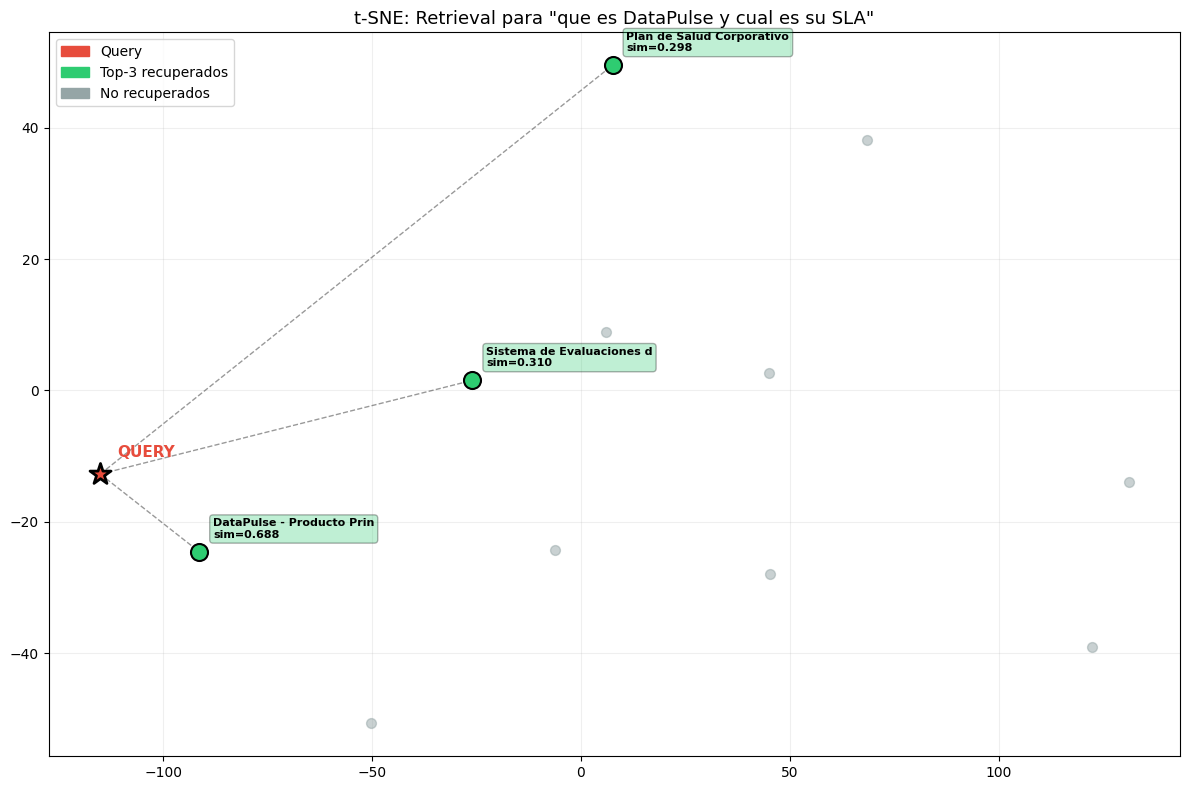

In [14]:
# Obtener embeddings de todos los chunks y de la query
query_viz = "que es DataPulse y cual es su SLA"

all_texts_viz = [doc.page_content for doc in documents] + [query_viz]
resp = client.embeddings.create(input=all_texts_viz, model="text-embedding-3-small")
all_embs = np.array([e.embedding for e in resp.data])

# Separar
chunk_embs = all_embs[:-1]
query_emb = all_embs[-1:]

# Calcular similitudes
similarities = cosine_similarity(query_emb, chunk_embs)[0]
top_k = 3
top_indices = np.argsort(similarities)[::-1][:top_k]

# t-SNE
perplexity = min(5, len(all_texts_viz) - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
coords = tsne.fit_transform(all_embs)

fig, ax = plt.subplots(figsize=(12, 8))

# No recuperados (gris)
for i in range(len(documents)):
    if i not in top_indices:
        ax.scatter(coords[i, 0], coords[i, 1], c='#95a5a6', s=50, alpha=0.5, zorder=2)

# Recuperados (verde)
for idx in top_indices:
    ax.scatter(coords[idx, 0], coords[idx, 1], c='#2ecc71', s=150,
              edgecolors='black', linewidth=1.5, zorder=3)
    source = documents[idx].metadata.get('source', '')[:25]
    ax.annotate(f"{source}\nsim={similarities[idx]:.3f}",
               (coords[idx, 0], coords[idx, 1]),
               fontsize=8, fontweight='bold',
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='#2ecc71', alpha=0.3))
    # Linea
    ax.plot([coords[-1, 0], coords[idx, 0]],
            [coords[-1, 1], coords[idx, 1]],
            'k--', alpha=0.4, linewidth=1)

# Query (rojo)
ax.scatter(coords[-1, 0], coords[-1, 1], c='#e74c3c', s=250,
          marker='*', edgecolors='black', linewidth=2, zorder=4)
ax.annotate('QUERY', (coords[-1, 0], coords[-1, 1]),
           fontsize=11, fontweight='bold', color='#e74c3c',
           xytext=(12, 12), textcoords='offset points')

legend_elements = [
    mpatches.Patch(color='#e74c3c', label='Query'),
    mpatches.Patch(color='#2ecc71', label=f'Top-{top_k} recuperados'),
    mpatches.Patch(color='#95a5a6', label='No recuperados'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
ax.set_title(f't-SNE: Retrieval para "{query_viz}"', fontsize=13)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

---
## Seccion 9: Experimentar con k

El parametro **k** controla cuantos documentos recupera el retriever. Veamos como afecta la calidad de las respuestas.

In [15]:
pregunta_k = "Que beneficios de capacitacion ofrece NovaTech y como funcionan las evaluaciones?"

for k in [1, 3, 5]:
    # Crear retriever con diferente k
    retriever_k = vectorstore.as_retriever(search_kwargs={"k": k})

    # Crear chain
    chain_k = (
        {"context": retriever_k | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    respuesta_k = chain_k.invoke(pregunta_k)

    # Ver que documentos se recuperaron
    docs_k = retriever_k.invoke(pregunta_k)
    sources = set(d.metadata.get('source', 'N/A') for d in docs_k)

    print(f"\n{'=' * 60}")
    print(f"k = {k}")
    print(f"{'=' * 60}")
    print(f"Fuentes recuperadas: {sources}")
    print(f"\nRespuesta:")
    print(respuesta_k[:400])
    if len(respuesta_k) > 400:
        print("...")


k = 1
Fuentes recuperadas: {'Sistema de Evaluaciones de NovaTech'}

Respuesta:
No tengo información sobre eso en mi base de conocimiento.



k = 3
Fuentes recuperadas: {'Sistema de Evaluaciones de NovaTech', 'Proceso de Onboarding en NovaTech Solutions', 'Programa de Capacitacion y Desarrollo NovaTech'}

Respuesta:
NovaTech ofrece un Programa de Capacitación y Desarrollo que incluye un presupuesto anual de $25,000 MXN para cada empleado, destinado a capacitación profesional. Este presupuesto cubre cursos online en plataformas como Udemy, Coursera y Platzi, asistencia a conferencias (hasta dos al año con viáticos), y certificaciones técnicas en áreas como AWS, GCP y Kubernetes. Además, NovaTech cuenta con una
...



k = 5
Fuentes recuperadas: {'Politica de Trabajo Remoto NovaTech', 'Proceso de Onboarding en NovaTech Solutions', 'Sistema de Evaluaciones de NovaTech', 'Politica de Vacaciones de NovaTech Solutions', 'Programa de Capacitacion y Desarrollo NovaTech'}

Respuesta:
NovaTech ofrece un Programa de Capacitación y Desarrollo que incluye un presupuesto anual de $25,000 MXN para capacitación profesional. Este presupuesto cubre cursos online en plataformas como Udemy, Coursera y Platzi, asistencia a conferencias (hasta 2 al año con viáticos), y certificaciones técnicas en áreas como AWS, GCP y Kubernetes. Además, la plataforma interna LearnHub ofrece más de 150 cur
...


> **Observa:** Con k=1 la respuesta puede ser incompleta (solo cubre un tema). Con k=3 obtenemos un buen balance. Con k=5 tenemos mas contexto pero el modelo puede incluir informacion no relevante.

---
## Resumen

### Que aprendimos

| Paso | Componente | Funcion |
|------|------------|---------|
| 1 | Documentos | Base de conocimiento con informacion especifica |
| 2 | Chunking | Dividir documentos en fragmentos manejables |
| 3 | Embeddings | Convertir texto a vectores numericos |
| 4 | Vector Store | Almacenar y buscar por similitud semantica |
| 5 | Retriever | Encontrar los k documentos mas relevantes |
| 6 | Generator | LLM que genera respuesta basada en contexto |

### Cuando usar RAG

- Cuando necesitas respuestas basadas en datos privados o actualizados
- Cuando quieres reducir alucinaciones del modelo
- Cuando la informacion cambia frecuentemente
- Cuando necesitas trazabilidad (saber de donde viene la respuesta)

### Checklist de consolidacion

- [ ] Puedo explicar que es RAG y por que es necesario
- [ ] Se implementar un pipeline RAG completo con LangChain
- [ ] Entiendo la diferencia entre retrieval y generacion
- [ ] Puedo construir chains con LCEL (pipe operator)
- [ ] Comprendo el impacto del parametro k en las respuestas
- [ ] Se comparar resultados sin RAG vs con RAG